# Deploying A Machine Learning Model on Amazon EC2 as RESTful API using *Flask, Gunicorn and nginx* 

## Table of Contents
* [1. Introduction](#Deep_neural)

* [2. Saving a trained model - Python Pickling](#Implementation)

* [3. Data Preparation,Training, Predictions, Pickling and Loading](#Loan_default)

* [4. Creating a Flask web service - RESTful API and running it locally](#Flask)    
    
* [5. Creating a Flask Web service on Amazon EC2 using *gunicorn* and *nginx*](#amazon)

* [6. Gunicorn as Service](#gunicorn)
    


## 1. Introduction <a class="anchor" id="Deep_neural"></a>

Machine Learning models don't exist in a vacuum. Time and money is spent on collecting data, storing it and fitting ML models to solve business problems. ML models provide value when they make predicitons about future scenarios and help make business decisions (whether it is Marketing Analytics, customer churn predictions, image recognition, IoT applications like Remaining Useful Life etc). So trained models need to be available either through the creation of web applications to be used by certain groups within the company or completely integrated into other business applications like dashboards for making decisions. One of the most common way of deploying ML models is by using an endpoint (web application/API). In this notebook I created a RESTful API using Python Flask framework embedding the Deep Learning model I trained in <a href="https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Neural%20Network%20SGD/Loan_Default_Binary_Classification.ipynb">the previous study </a> and productionized it on an <a href="https://aws.amazon.com/ec2/?nc2=h_ql_prod_fs_ec2">Amazon Web Service EC2 instance</a> (The deep neural network using Stochastic gradient descent algorithm trained on <a href="https://www.kaggle.com/wordsforthewise/lending-club">the Lending Club Loan Default Dataset</a> to be more precise). This is my first attempt at productionizing a ML model, so I might not be following industry best practices for scalability to inorder to deal with many concurrent users. I will try to explore this more in future notebooks. Disclaimer, this is just one of the many ways to productionize a ML model. <a href="https://aws.amazon.com/sagemaker/"> AWS SageMaker</a> has machine learning deployment capabilities which is really streamlined, <a href="https://aws.amazon.com/lambda/">AWS Lambda</a> provides serverless execution which might be more appropriate for certain applications. <a href ="https://aws.amazon.com/elasticbeanstalk/">AWS Beanstalk </a> is probably the best service for web applications and APIs when scaling is very important. The general schematic of the RESTful API is shown below.

![image](API_schem.PNG)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
%matplotlib inline
warnings.filterwarnings('ignore')

## 2. Saving a trained model - Python Pickling <a class="anchor" id="Implementation"></a>
Here is a excerpt about Pickle from <a href="https://docs.python.org/3/library/pickle.html">Python.org</a> *“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshalling,” 1 or “flattening”; however, to avoid confusion, the terms used here are “pickling” and “unpickling”.*

The python class implemented in the previous study needs to be update to include a way to save the weights and bias matrices and the scaling parameters which are a result of training process. Mechanism to read in the weights, biases and scaling parameters also needs to be part of the class so that predictions based on saved models can be made. Pickling and unpickling as described above is implemented as a part of the class through 2 different functions *save_model* and *load_model*. The entire implementation is shown below.

In [2]:
import pickle
class dense_NN_sgd():
    def __init__(self,seed=10):        
        self.nn_struct={}
        self.index = int(0)
        self.W = {}
        self.b = {}
        self.Z = {}
        self.A = {}
        self.dA = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        #self.cost = []
        self.cost_list=np.array([])
        self.random = np.random.RandomState(seed)
    
    ###################Scaler###################
    def scaler_fit(self,X):
        self.X_max = X.max(0)
        self.X_min = X.min(0)
            
    def scaler_transform(self,X):
        return (X-self.X_min)/(self.X_max-self.X_min)
    
    ############################################
    
    #################Activation functions & derivatives###################
    ############Activation Functions############
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def RELU(self,x):
        return np.maximum(0,x)
    
    def tanh(self,x):
        return np.tanh(x)
    
    def leakyRELU(self,x):
        return np.maximum(0.01*x,x)
    
    #############Derivatives#####################
    def dsigmoid(self,X):
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def dRELU(self,x):
        return np.where(x>=0.0,1,0)   
    
    def dtanh(self,X):
        return (1-np.square(np.tanh(X)))
    
    def dleakyRELU(self,x):
        return np.where(x>=0,1.0,0.01)
    
    ##############################################
    
    def g(self,X,fun="RELU"):
        if fun=="RELU":
            return self.RELU(X)
        if fun=="tanh":
            return self.tanh(X)
        if fun=='sigmoid':
            return self.sigmoid(X)
        if fun=='leakyRELU':
            return self.leakyRELU(X)
    
    def g_prime(self,X,fun="RELU"):
        if fun=="RELU":
            return self.dRELU(X)
        if fun=="tanh":
            return self.dtanh(X)
        if fun=='sigmoid':
            return self.dsigmoid(X)
        if fun=='leakyRELU':
            return self.dleakyRELU(X)
    ####################################################################################
    
    ################################Cost Function########################################
    def cost(self,y_true,y_pred):
        m = y_true.shape[1]
        return -np.sum(np.multiply(y_true,np.log(y_pred))+np.multiply((1-y_true),np.log(1-y_pred)))/m
    
    #####################################################################################
           
    def input_data(self,X,y):
        self.scaler_fit(X)
        X_scaled = self.scaler_transform(X)
        self.X = X_scaled
        self.y = y.reshape((1,-1))
        self.m = X_scaled.T.shape[1]
        self.n0 = X_scaled.shape[1]
        

    def add_layer(self,nodes=5,act_fun='RELU'):
        self.index += 1
        add_lay = {self.index:[nodes,act_fun]}
        self.nn_struct.update(add_lay)
        
    def summary(self):
        n_param = 0
        L = max(sorted(self.nn_struct))
        for i in range(1,L+1):
            nodes = self.nn_struct[i][0]
            act_fun = self.nn_struct[i][1]
            print("Layer:",i," Node Count:",nodes," Activation Function:",act_fun)
            if i==1:
                n_param += self.n0*nodes + nodes
            else:
                n_param += self.nn_struct[i-1][0]*nodes + nodes
        print("Total Number of Trainable params:",n_param)
        
    
    ######################## Randomize the weight arrays#######################
    def nn_compile(self):
        self.L = max(sorted(self.nn_struct))
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                W = 0.02*self.random.rand(value[0],self.n0)
                b = np.zeros((value[0],1))
                self.W.update({key:W})
                self.b.update({key:b})
            else:
                W = 0.02*self.random.rand(value[0],self.nn_struct[key-1][0])
                b = np.zeros((value[0],1))
                self.W.update({key:W})
                self.b.update({key:b})
    ###########################################################################
    
    def forward_prop(self,verbose=False):
        L = max(sorted(self.nn_struct))
        ##############Forward Propagation###############
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key],self.X_batch.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],self.A[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            self.Z.update({key:Z})
            self.A.update({key:A})
        ################################################
        
    
    def back_prop(self):
        ############### Total Number of Layers based on Input###########
        L = max(sorted(self.nn_struct))
        ###############Back Propagation #################
        dAL = - (np.divide(self.y_batch, self.A[L]) - np.divide(1 - self.y_batch, 1 - self.A[L]))
        dZ = dAL*self.g_prime(self.Z[L],fun=self.nn_struct[L][1])
        dW = np.dot(dZ,self.A[L-1].T)/self.m
        dB = np.sum(dZ,axis=1,keepdims=True)/self.m
        dAL_1 =  np.dot(self.W[L].T,dZ)
        
        self.dA.update({L:dAL})
        self.dZ.update({L:dZ})
        self.dW.update({L:dW})
        self.dB.update({L:dB})
        self.dA.update({L-1:dAL_1})
        
        
        for i in range(L-1,0,-1):
            dZ = self.dA[i]*self.g_prime(self.Z[i],fun=self.nn_struct[i][1])
            dW = np.dot(dZ,self.A[i-1].T)/self.m
            dB = np.sum(dZ,axis=1,keepdims=True)/self.m                    
            dAL_1 = np.dot(self.W[i].T,dZ)
            if(i!=1):
                self.dA.update({i-1:dAL_1})
            self.dZ.update({i:dZ})
            self.dW.update({i:dW})
            self.dB.update({i:dB})
         
        for i in range(1,L+1,1):
            self.W[i]=self.W[i]-self.alpha*self.dW[i]
            self.b[i]=self.b[i]-self.alpha*self.dB[i]
    
    def fit(self,alpha=0.01,epochs=100,batch_size = 10,call_back = 10,verbose=False):
        self.alpha = alpha
        indices = np.arange(self.X.shape[0])
        cb = 0
        for i in range(1,epochs):
            self.random.shuffle(indices)            
            for start_idx in range(0,self.m-batch_size+1,batch_size):
                batch_idx = indices[start_idx:start_idx+batch_size]
                self.X_batch = self.X[batch_idx]
                #### Asssing A0 to X_batch, the zeroth layer##
                self.A.update({0:self.X_batch.T})
                self.y_batch = self.y[:,batch_idx]
                self.forward_prop(verbose)                
                self.back_prop()
            cost = self.cost(self.y,self.forward_predict(self.X))
            self.cost_list = np.append(self.cost_list,cost)
            #i=len(self.cost_list)
            if verbose:
                print("Epoch: ",i,"Binary Cross Entropy Cost: ",cost)
            if np.isnan(self.cost_list[i-1]):
                break
            if i>1:                
                if (self.cost_list[i-2]-self.cost_list[i-1])<0:
                    cb +=1
                if cb > call_back:
                    break
    
    def forward_predict(self,X_new):
        L = max(sorted(self.nn_struct))
        X_scaled = X_new
        m = X_new.shape[0]
        A_dict = {}
        Z_dict = {}
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key], X_scaled.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],A_dict[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            Z_dict.update({key:Z})
            A_dict.update({key:A})
        y_pred = A_dict[L]               
        return y_pred
    
    def predict(self,X_new):
        L = max(sorted(self.nn_struct))
        X_scaled = self.scaler_transform(X_new)
        m = X_new.shape[0]
        A_dict = {}
        Z_dict = {}
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key], X_scaled.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],A_dict[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            Z_dict.update({key:Z})
            A_dict.update({key:A})
        y_pred = A_dict[L].reshape(-1)
        y_class = np.zeros(m)
        y_class[y_pred>0.5]=1
        
        return y_pred,y_class
    
    def save_model(self,name="dnn_SGD"):
        model = [self.nn_struct,self.X_min,self.X_max,self.W,self.b]
        with open(name+'.pkl','wb') as filehandle:
            pickle.dump(model, filehandle)
            
    def load_model(self,name):
        try:
            with open(name, 'rb') as filehandle:
            # read the data as binary data stream
                model = pickle.load(filehandle)
                self.nn_struct = model[0]
                self.X_min = model[1]
                self.X_max = model[2]
                self.W = model[3]
                self.b = model[4]
        except:
            print("Error - Valid saved model was not found")

## 3. Data Preparation,Training, Predictions, Pickling and Loading <a class="anchor" id="Loan_default"></a>

The details of the data preparation and EDA were described in <a href = https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Neural%20Network%20SGD/Loan_Default_Binary_Classification.ipynb>a previous notebook</a> and <a href="https://arunj2014.netlify.app/blog/loan_default_notebook_prt1/">a blogpost</a>. The main goal here is to test out whether the newly implemented functions perform the pickling of the trained parameters and are able to load them back to make predictions for a new input. 

In [3]:
def reduce_Loan_dataset(df):
    df = df.dropna(axis=0)
    df['loan_status_new']=0
    df.loc[df['loan_status']=='Default','loan_status_new']=1
    df = df.drop(columns=['loan_status'],axis=1)
    df = pd.concat([df,pd.get_dummies(df['term'])],axis=1)
    df = pd.concat([df,pd.get_dummies(df['grade'])],axis=1)
    df = pd.concat([df,pd.get_dummies(df['emp_length'])],axis=1)
    df = pd.concat([df,pd.get_dummies(df['home_ownership'])],axis=1)
    df = pd.concat([df,pd.get_dummies(df['verification_status'])],axis=1)
    df = pd.concat([df,pd.get_dummies(df['purpose'])],axis=1)
    df = df.drop(columns=['term','grade','emp_length','home_ownership','verification_status','purpose'],axis=1)    
    return df

In [4]:
df = reduce_Loan_dataset(pd.read_csv("loan_simplified_2.csv"))

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [6]:
X = df.drop(columns=['loan_status_new'],axis=1).values
y = df['loan_status_new'].values

### Stratified split of the dataset

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

### Training the Neural Network with mini batch Stochastic Gradient Descent

In [8]:
nn3= dense_NN_sgd()
nn3.input_data(X_train,y_train)

# Adding layers using the add_layer function. 2 layers, a tanh and leakyRELU were added.
nn3.add_layer(nodes=200,act_fun='tanh')
nn3.add_layer(nodes=150,act_fun='tanh')
nn3.add_layer(nodes=100,act_fun='tanh')
nn3.add_layer(nodes=100,act_fun='tanh')

# Addition of the final single node sigmoid layer is mandatory for binary classification task
nn3.add_layer(1,act_fun='sigmoid')

# This randomly initializes all the weight matrices and assigns zeros to the bias arrays
nn3.nn_compile()
nn3.summary()

Layer: 1  Node Count: 200  Activation Function: tanh
Layer: 2  Node Count: 150  Activation Function: tanh
Layer: 3  Node Count: 100  Activation Function: tanh
Layer: 4  Node Count: 100  Activation Function: tanh
Layer: 5  Node Count: 1  Activation Function: sigmoid
Total Number of Trainable params: 66651


In [9]:
nn3.fit(alpha=0.8,epochs=250,batch_size=30,call_back=2000,verbose=False)

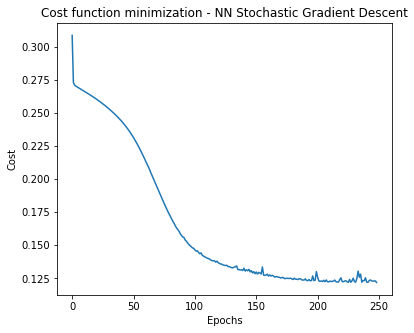

In [10]:
plt.figure(figsize=(6,5))
plt.plot(nn3.cost_list)
plt.title("Cost function minimization - NN Stochastic Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

### Prediction on the test dataset and Performance metrics

Confusion Matrix NN Stochastic Gradient Descent with mini batch 

[[9.99135994e-01 8.64005530e-04]
 [3.79023884e-01 6.20976116e-01]]


Classification Report 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11574
           1       0.98      0.62      0.76       963

    accuracy                           0.97     12537
   macro avg       0.98      0.81      0.87     12537
weighted avg       0.97      0.97      0.97     12537



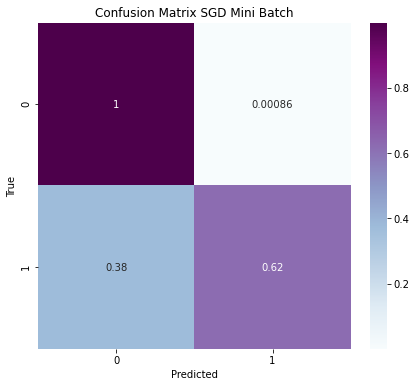

In [11]:
y_prob_nn3,y_class_nn3 = nn3.predict(X_test)
print("Confusion Matrix NN Stochastic Gradient Descent with mini batch \n")
cf_nn3 = confusion_matrix(y_test,y_class_nn3,normalize="true")
print(cf_nn3)
plt.figure(figsize=(7,6))
ax = sns.heatmap(cf_nn3,annot=True,cmap="BuPu")
ax.set_title("Confusion Matrix SGD Mini Batch")
ax.set(xlabel = "Predicted",ylabel = "True")
print('\n')
print('Classification Report \n')
print(classification_report(y_test,y_class_nn3))

### Saving the model and reloading it for prediction on new data
The *.pkl*  extension is directly added to the name during saving. While reading make sure the entire file name along with the *.pkl* is provided. 

In [12]:
nn3.save_model(name="dnn_SGD")

Creation of a new model object of class *dense_NN_sgd* and reading in the saved model. Please note the pickled file saves only the weights, biases and the scaling parameters. So it needs to be read into an object of *Class dense_NN_sgd* to work. 

In [13]:
nn4 = dense_NN_sgd()

In [14]:
nn4.load_model(name="dnn_SGD.pkl")

Reading in new data and making predictions with the loaded model

In [15]:
df2 = reduce_Loan_dataset(pd.read_csv("loan_simplified_3.csv"))
X = df2.drop(columns=['loan_status_new'],axis=1).values
y = df2['loan_status_new'].values

### Prediction & Model Evaluation on new data

Confusion Matrix NN new data 

[[0.99847991 0.00152009]
 [0.39116292 0.60883708]]


Classification Report 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     87495
           1       0.97      0.61      0.75      7378

    accuracy                           0.97     94873
   macro avg       0.97      0.80      0.87     94873
weighted avg       0.97      0.97      0.96     94873



[Text(42.0, 0.5, 'True'), Text(0.5, 33.0, 'Predicted')]

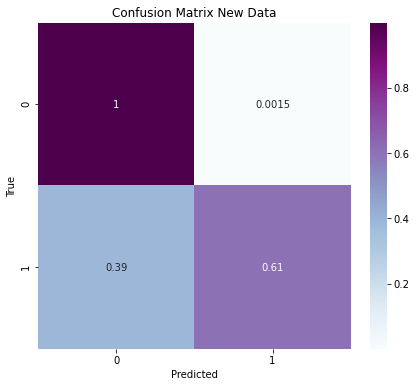

In [16]:
y_prob_nn4,y_class_nn4 = nn4.predict(X)

print("Confusion Matrix NN new data \n")
cf_nn4 = confusion_matrix(y,y_class_nn4,normalize="true")
print(cf_nn4)
print("\n")
print('Classification Report \n')
print(classification_report(y,y_class_nn4))

plt.figure(figsize=(7,6))
ax = sns.heatmap(cf_nn4,annot=True,cmap="BuPu")
ax.set_title("Confusion Matrix New Data")
ax.set(xlabel = "Predicted",ylabel = "True")

## 4. Creating a Flask web service - RESTful API and running it locally <a class="anchor" id="Flask"></a>

Flask is a microframework for creating web applications and APIs using Python. The moto of Flask is to keep things very simple and extensible. The below code snippet shows a Flask application which embeds the implemented and trained neural network as a RESTful API. You can read more about REST API in this <a href="https://searchapparchitecture.techtarget.com/definition/RESTful-API">article</a> but the basic premise is, it is a method by which different software programs can communicate with each other over the network.

*Flask* and its extension package *flask_restful* have been used to create the API end point as shown below. The code is stored in a file named *app.y*. The below API can only deal with POST HTTP requests as indicated by the function and the class which inherits the *Resource* class from *flask_restful* package. This means both the inputs to and the output from the API are in json format. 

In [ ]:
# Don't execute the code below. Copy the code snippet into a file called app.py and run it from the console.
import numpy as np
from nn_sgd import dense_NN_sgd
from flask import Flask, request
from flask_restful import Resource, Api

app = Flask(__name__)
api = Api(app)

class predict_default(Resource):
    def post(self):
        inp_json = request.get_json()
        X = np.array(inp_json['input'])
        nn4 = dense_NN_sgd()
        nn4.load_model(name="dnn_SGD.pkl")
        y_prob_nn4,y_class_nn4 = nn4.predict(X)
        result = {"y_prob":y_prob_nn4[0],"y_class":y_class_nn4[0]}
        
        return result

api.add_resource(predict_default,'/')

if __name__ =='__main__':
    app.run(debug=True)

The app can be test by running it locally. Open a terminal window and change the directory to the one containing the file Run the file *app.py* using the python keyword from the console as shown in the screenshot below. The message displayed should say that the app is running and should give an URL. 
![image](Loan_default_API_run.JPG)

Python *requests* package has been used to deal with the input to and output from the REST API (the API running locally and on AWS EC2 instance). The *post* function defined as a part of the *predict_default* takes in an json object as input and extracts the feature array and feeds it into the *predict* function part of the *dense_NN_sgd* class which is packaged along with *app.py*. The weights, biases and scaling parameters are loaded before the predictions are made. The current implementation of the REST API can take only one row of data. Care must be taken that the inut is in json ingestible format. A single row from a pandas dataframe or a numpy array needs to be converted into a simple list before it can made input into a python dictionary (with key value pairs). The python dictionary object is very similar in structure to a json object and the *requests* package is able to deal with dictionaries converitng them into json objects.
So the 1st step is to convert a single row of the numpy array into a dictionary/json object. The dictionary key name of *input* is used in the API. Hence a dictionary with a single key of *input* needs to be created before feeding it to the *request* *post* function.

In [18]:
X_feature = X[10].reshape(1,-1) ### Reshaping the array to conform to the (m rows, n columns) format.
X_feature = X_feature.tolist() ### Making the numpy array into a list

Creating the input dictionary with single key *input*. The list has values for the all features needed for the model to work. Please note the dimensions of the input vector should match that one required for the trained model.

In [19]:
inp = {'input':X_feature}
print(inp)

{'input': [[35000.0, 9.99, 1129.19, 175000.0, 29.81, 0.0, 10.0, 27342.0, 43.4, 17.0, 0.0, 35601.65, 601.65, 34511.31, 61.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}


The *post* request takes in a URL and a json object as input. The URL specified is the server address at which the API endpoint has been stood up.The result of the post request is displayed below. The output basically has two components, the probability of defaulting on the loan and class label associated with the loan - 0 corresponds to "Won't Default (Good)" the loan & 1 corresponds to "Will Default" the loan.

In [20]:
import requests
from flask import jsonify

URL = "http://127.0.0.1:5000/"
r1 = requests.post(url=URL,json=inp)
print(r1.text)

{
    "y_prob": 6.853156834293194e-09,
    "y_class": 0.0
}



This confirms that the Flask REST API is working as intended and is able to produce the result of the prediction from the trained Deep Learning model when a HTTP post request is sent to it. The next step is to productionize this Flask REST API as a web service on the cloud (Amazon EC2 instance)

## 5. Creating a Flask Web service on Amazon EC2 using *gunicorn* and *nginx*<a class="anchor" id="amazon"></a>

As explained before Flask is a Python microframework but for it to run on a machine and be accessible it requires HTTP server. Gunicorn or 'Green Uniform" is a Web Server Gateway Interface (WSGI) server to run the Python backend applications (in this case the trained Deep Learning model or any other Python code). You can read more about <a href="A Web Server Gateway Interface (WSGI) server">gunicorn</a> here. When deploying  *gunicorn* it is strongly recommended it be used a behind a proxy server according to the developer page. *nginx* is a proxy server application which will be used to deploy the Flask API with gunicorn on an EC2 instance. You can read about proxy servers <a href="https://en.wikipedia.org/wiki/Proxy_server">here</a>. It basically acts as an intermediatory for requests from clients seeking resources from servers that provide those resources. In this case, the client request is a POST request for predicting the probability of Loan Default.

### Amazon EC2 instance and installation of associated packages

I won't be describing how to create an EC2 instance as it has been covered in many other places. Please refer to those pages through a google search. The descripton here will cover what packages to install on EC2, how to deploy the Flask API on EC2 and access it from the client machine. I spun up a *t2.micro* Ubuntu 18.04 LTS server on EC2 and connected to it from my windows machine using the PuTTy utility.
![image](EC2_putty.PNG)
![image](Putty.PNG)

Install the following using sudo apt-get root commands on the EC2 instance
1. *Python 3.X*
2. *pip3* package manager
3. pip3 install as the Python libraries and dependencies for the Flask Application to work. In my case it was flask, flask-restful,numpy (since the Deep Neural network doesn't use any specialized ML packages those libraries are not required. But if a scikit-learn model has to be productionized then those libraries need to be installed in this step).
4. *gunicorn3* (3 is for Python 3.x)
5. *nginx* proxy web server

### The Flask Application

Create a new directory and copy over the *app.py* file over into the directory along with the dependencies. In my case, I copied over the following files
1. *app.py* - the python file containing the Flask app.
1. *nn_sgd.py* - file containing the Deep neural network python class definition with all the functions 
2. *dnn_SGD.pkl* - the pickled file which contains all the trained weights, biases and scaling parameters

![image](flask_app_files.PNG)
I used WinSCP to connect to the EC2 instance from the my Windows machine to transfer the files.

### The *nginx* server

Create the following *nginx* proxy server configuration file using vim. Give it a name. Here the server name corresponds to IPv4 public address of the EC2 instance. This file should be created in the */etc/nginx/sites-enabled* folder using *sudo vim flaskapp*. The proxy pass needs to be specified with web address as shown below with port 8000.

In [ ]:
server{
   listen 80;
   server_name 3.23.114.57;

   location /{
        proxy_pass http://127.0.0.1:8000;
   }

}

Close and save the flaskapp configuration file and to reflect the addition of a new service run the nginx restart command.
*sudo service nginx restart*. Make sure this runs without errors.
![image](nginx_restart.PNG)

### Run the Flask Application

Change the directory to the one which has the Flask Application and its dependencies. Issue the following command to run the app using *gunicorn*. 

*gunicorn3 app:app*

![image](gunicorn_run_app.PNG)

The message should indicate the url and the port at which the gunicorn is listening. The application is now running and can be accessed over the internet at the EC2 instance IPv4 public address. Before this can be done, port 80 (specified in the *nginx* proxy server configuration file) needs to be opened using Security group in EC2 instance configuration page.

![image](security1.PNG)

Click on launch wizard 6 and enable a HTTP inbound request rule at PORT 80. 

![image](inbound.PNG)

Since this application is an API which can support only post requests the previous code accessed the API running locally  can be used as is. The only difference in the URL. The new URL will be the public IP of the EC2 instance with port 80 appended after the colon. The results of the request is shown below. The result shows that the service is running and gives a result when requested. 

In [25]:
### AWS EC2 instance public IPv4 address appended with port 80 at which the API is accessible
URL = "http://3.128.189.172:80/" 
r2 = requests.post(url=URL,json=inp)
print(r2.text)

{"y_prob": 0.9996627018882251, "y_class": 1.0}



The requests can also be made sequentially using a for loop as shown below

In [26]:
for i in range(290,300):
    X_feature  = X[i].reshape(1,-1)
    X_feature = X_feature.tolist()
    inp = {'input':X_feature}
    r1 = requests.post(url=URL,json=inp)
    print(r1.text)

{"y_prob": 0.0045522095917126535, "y_class": 0.0}

{"y_prob": 0.011071436510687297, "y_class": 0.0}

{"y_prob": 0.06882735456943723, "y_class": 0.0}

{"y_prob": 0.3630001605624724, "y_class": 0.0}

{"y_prob": 0.06998014215583047, "y_class": 0.0}

{"y_prob": 0.02390334187732422, "y_class": 0.0}

{"y_prob": 0.010344565352920972, "y_class": 0.0}

{"y_prob": 0.0003092682325069546, "y_class": 0.0}

{"y_prob": 0.009420535360746959, "y_class": 0.0}

{"y_prob": 0.9996627018882251, "y_class": 1.0}



The current version of the API is unable to take full dataframe input and return arrays for probability of default and the corresponding class label, but this is something which is easily added.

In [ ]:
# import json
# def post_predict(X):
#     X_feature  = X.reshape(1,-1)
#     X_feature = X_feature.tolist()
#     inp = {'input':X_feature}
#     r1 = requests.post(url=URL,json=inp)
#     result = json.loads(r1.text)
#     y_prob = result['y_prob']
#     y_class = result['y_class']
#     return y_prob,y_class

In [ ]:
# np.apply_along_axis(post_predict,1,X)

## 6. Gunicorn as Service <a class="anchor" id="gunicorn"></a>

The Flask app developed in the previous section was run using the continuous gunicorn command. Running gunicorn as a Service, streamlines this process without having to run it continuously, meaning other tasks can be performed in the same terminal window and the app runs in the background. Follow the steps described below to run gunicorn as a service

1. Create a *gunicorn3.service* file in the */etc/systemd/system* folder and copy over the contents. Make sure to specify the correct working directory, one which has the app.py file

In [ ]:
[Unit]
Description=Gunicorn service
After = network.target

[Service]
User=ubuntu
Group=www-data
WorkingDirectory=/home/ubuntu/Loan_Default
ExecStart=/usr/bin/gunicorn3 --workers 3 --bind unix:Loan_Default.sock -m 007 app:app

2. Make sure to save the changes and reload the daemon. 
3. Start the servivce.
4. The status of the service can be checked next using the status command. See the image below

![image](gunicorn_as_service2.PNG)

A sock file *Loan_Default.sock* created in the app folder when the service is started.
![image.png](gunicorn_as_service3.PNG)

5. The nginx file (*flaskapp*) needs to be updated to reflect the path of gunicorn socket file. The proxy_pass now needs to point to the *Loan_Default.sock* file. Full path needs to be provided 

In [ ]:
server{
   listen 80;
   server_name 3.23.114.57;

   location /{
        proxy_pass http://unix:/home/ubuntu/Loan_Default/Loan_Default.sock;
   }

}

6. Restart *nginx* as before using *sudo nginx restart*
7. Finally restart gunicorn3 service using *sudo service gunicorn3 restart*

Now the API can be accessed at the same web address, essentially the previous code for POST request can be used.

In [28]:
URL = "http://3.128.189.172:80/" 
r2 = requests.post(url=URL,json=inp)
print(r2.text)

{"y_prob": 0.031438942393929775, "y_class": 0.0}



In [30]:
for i in range(410,420):
    X_feature  = X[i].reshape(1,-1)
    X_feature = X_feature.tolist()
    inp = {'input':X_feature}
    r1 = requests.post(url=URL,json=inp)
    print(r1.text)

{"y_prob": 0.02931191530248862, "y_class": 0.0}

{"y_prob": 0.08138355496566413, "y_class": 0.0}

{"y_prob": 0.016775204341364425, "y_class": 0.0}

{"y_prob": 0.004764906745274596, "y_class": 0.0}

{"y_prob": 0.015333884914059164, "y_class": 0.0}

{"y_prob": 0.9904398010484752, "y_class": 1.0}

{"y_prob": 0.010803313585206009, "y_class": 0.0}

{"y_prob": 0.04364642788137709, "y_class": 0.0}

{"y_prob": 0.012045131766331624, "y_class": 0.0}

{"y_prob": 0.02252981564017505, "y_class": 0.0}



This concludes the deployment of the Flask API using gunicorn and nginx. A future notebook will explore the use for Amazon Elastic Beanstalk for deploying the API.